In [1]:
import numpy as np 
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [2]:
DATA_ROOT = Path('/content/drive/Othercomputers/Мое устройство Компьютер/Google.Disk/Colab Notebooks/data/')
TRAIN_PATH = DATA_ROOT /'train_tweets_token.csv'

df_train = pd.read_csv(TRAIN_PATH, sep=',')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    31962 non-null  int64 
 1   label                 31962 non-null  int64 
 2   tweet                 31959 non-null  object
 3   tweet_token           31962 non-null  object
 4   tweet_token_filtered  31962 non-null  object
 5   tweet_stemmed         31962 non-null  object
 6   tweet_lemmatized      31962 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.7+ MB


#Тема «Создание признакового пространства»
Продолжим обработку данных с Твиттера.

1. Создайте мешок слов с помощью sklearn.feature_extraction.text.CountVectorizer.fit_transform(). Применим его к 'tweet_stemmed' и 'tweet_lemmatized' отдельно.
- Игнорируем слова, частота которых в документе строго превышает порог 0.9 с
помощью max_df.
- Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
- Исключим стоп-слова с помощью stop_words='english'.
- Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с помощью CountVectorizer.get_feature_names().


In [3]:
def feature_extract(data, model_vectorizer):
    # Создаем модель
    vectorizer = model_vectorizer.fit_transform(data)

    # Отобразим Bag-of-Words модель как DataFrame
    feature_names = model_vectorizer.get_feature_names_out()
    vectorizer = pd.DataFrame(vectorizer.toarray(), columns = feature_names)

    return vectorizer

In [4]:
count_vectorizer = CountVectorizer(max_df=0.9, max_features=1000, stop_words='english')

#'tweet_stemmed' 
# Отобразим Bag-of-Words модель как DataFrame
tweet_stemmed_bag_of_words = feature_extract(df_train['tweet_stemmed'], count_vectorizer)

#'tweet_lemmatized' 
# Отобразим CountVectorizer модель как DataFrame
tweet_lemmatized_bag_of_words = feature_extract(df_train['tweet_lemmatized'], count_vectorizer)


tweet_stemmed_bag_of_words.shape, tweet_lemmatized_bag_of_words.shape

((31962, 1000), (31962, 1000))

2. Создайте мешок слов с помощью sklearn.feature_extraction.text.TfidfVectorizer.fit_transform(). Применим его к 'tweet_stemmed' и
'tweet_lemmatized' отдельно.
- Игнорируем слова, частота которых в документе строго превышает порог 0.9 с
помощью max_df.
- Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
- Исключим стоп-слова с помощью stop_words='english'.
- Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с
помощью TfidfVectorizer.get_feature_names().


In [5]:
#'tweet_stemmed' 
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=1000, stop_words='english')

#'tweet_stemmed' 
# Отобразим Bag-of-Words модель как DataFrame
tweet_stemmed_vectorizer = feature_extract(df_train['tweet_stemmed'], tfidf_vectorizer)

#'tweet_lemmatized' 
# Отобразим CountVectorizer модель как DataFrame
tweet_lemmatized_vectorizer = feature_extract(df_train['tweet_lemmatized'], tfidf_vectorizer)


tweet_stemmed_vectorizer.shape, tweet_lemmatized_vectorizer.shape

((31962, 1000), (31962, 1000))

3. Проверьте ваши векторайзеры на корпусе который использовали на вебинаре, составьте таблицу метод векторизации и скор который вы получили (в методах векторизации по изменяйте параметры что бы добиться лучшего скора) обратите внимание как падает/растёт скор при уменьшении количества фичей, и изменении параметров, так же попробуйте применить к векторайзерам PCA для сокращения размерности посмотрите на качество сделайте выводы.

CountVectorizer

In [6]:
# массив для ошибок, чтобы потом построить график
array_errors = pd.DataFrame(columns=['max_features', 'accuracy'])

tweet = 'tweet_lemmatized'

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_train[tweet], df_train['label'])

for i in np.arange(100, 1001, 50):
    
    vect = CountVectorizer(max_df=0.9, max_features=i, stop_words='english')
    vect.fit(df_train[tweet])

    xtrain_count =  vect.transform(train_x)
    xvalid_count =  vect.transform(valid_x)

    classifier = linear_model.LogisticRegression()
    classifier.fit(xtrain_count, train_y)
    predictions = classifier.predict(xvalid_count)

    array_errors = array_errors.append({'max_features': i, 'accuracy': round(accuracy_score(valid_y, predictions)*100,2)}, ignore_index=True)

In [7]:
array_errors.sort_values(by=['accuracy'], ascending=False)

,max_features,accuracy
18,1000.0,94.77
14,800.0,94.73
10,600.0,94.71
8,500.0,94.68
9,550.0,94.68
15,850.0,94.66
11,650.0,94.64
17,950.0,94.64
12,700.0,94.63
13,750.0,94.63


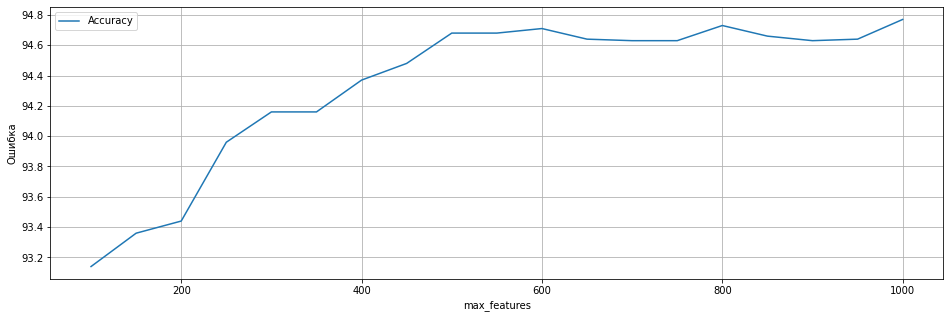

In [8]:
# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16,5))
plt.plot(array_errors['max_features'], array_errors['accuracy'], label = 'Accuracy')
plt.xlabel('max_features')
plt.ylabel('Ошибка')
plt.grid()
plt.legend()
plt.show()

TfidfVectorizer

In [9]:
# массив для ошибок, чтобы потом построить график
array_errors = pd.DataFrame(columns=['max_features', 'accuracy'])

tweet = 'tweet_lemmatized'

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_train[tweet], df_train['label'])

for i in np.arange(100, 1001, 50):
    
    vect = TfidfVectorizer(max_df=0.9, max_features=i, stop_words='english')
    vect.fit(df_train[tweet])

    xtrain_count =  vect.transform(train_x)
    xvalid_count =  vect.transform(valid_x)

    classifier = linear_model.LogisticRegression()
    classifier.fit(xtrain_count, train_y)
    predictions = classifier.predict(xvalid_count)

    array_errors = array_errors.append({'max_features': i, 'accuracy': round(accuracy_score(valid_y, predictions)*100,2)}, ignore_index=True)

In [10]:
array_errors.sort_values(by=['accuracy'], ascending=False)

,max_features,accuracy
16,900.0,94.86
15,850.0,94.84
18,1000.0,94.83
14,800.0,94.83
13,750.0,94.83
17,950.0,94.82
12,700.0,94.77
8,500.0,94.76
11,650.0,94.73
9,550.0,94.73


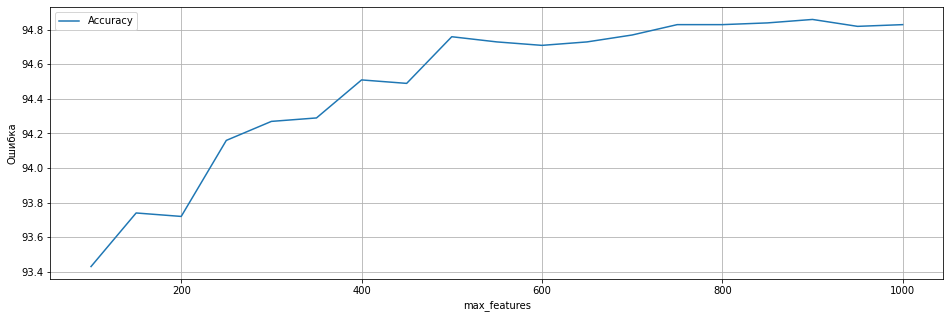

In [11]:
# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16,5))
plt.plot(array_errors['max_features'], array_errors['accuracy'], label = 'Accuracy')
plt.xlabel('max_features')
plt.ylabel('Ошибка')
plt.grid()
plt.legend()
plt.show()

 PCA

In [15]:
# массив для ошибок, чтобы потом построить график
array_errors = pd.DataFrame(columns=['n_components', 'accuracy'])

tweet = 'tweet_lemmatized'

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_train[tweet], df_train['label'])

for i in np.arange(10, 101, 10):
    vect = TfidfVectorizer(max_df=0.9, max_features=900, stop_words='english')
    vect.fit(df_train[tweet])

    xtrain_count =  vect.transform(train_x)
    xvalid_count =  vect.transform(valid_x)

    #PCA
    pca = PCA(n_components=i)
    pca.fit(xtrain_count.toarray())

    xtrain_pca = pca.transform(xtrain_count.toarray())
    xvalid_pca = pca.transform(xvalid_count.toarray())

    classifier = linear_model.LogisticRegression()
    classifier.fit(xtrain_pca, train_y)
    predictions = classifier.predict(xvalid_pca)

    array_errors = array_errors.append({'n_components': i, 'accuracy': round(accuracy_score(valid_y, predictions)*100,2)}, ignore_index=True)

In [16]:
array_errors.sort_values(by=['accuracy'], ascending=False)

,n_components,accuracy
7,80.0,94.13
9,100.0,94.09
8,90.0,94.04
6,70.0,93.99
5,60.0,93.97
4,50.0,93.62
3,40.0,93.58
0,10.0,93.48
2,30.0,93.47
1,20.0,93.38


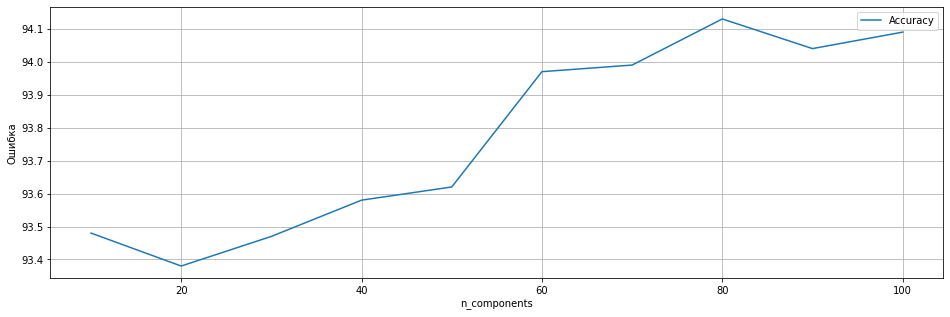

In [17]:
# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16,5))
plt.plot(array_errors['n_components'], array_errors['accuracy'], label = 'Accuracy')
plt.xlabel('n_components')
plt.ylabel('Ошибка')
plt.grid()
plt.legend()
plt.show()

### Вывод: Чем больше признаков мы создаём при векторизации текста, чем лучше модель определяет зависимости. При уменьшении размерности полученных векторов, мы соответственно теряем часть информации, что и показывает падение метрики нашей модели.